In [1]:
import torch, time, copy
import torch.nn as nn
import torch.optim as optim

from src.utils import *
from src.override_resnet import *

import matplotlib.pyplot as plt

def fuse_model(model) -> nn.Module:
    flag = False
    for m in model.modules():
        if m.__class__.__name__ == ResNet_quan.__name__:
            if flag == True:
                raise ValueError("ResNet_quan is already fused")
            flag = True
            torch.quantization.fuse_modules(
                m,
                ["conv1", "bn1", "relu"],
                inplace=True,
            )

        if type(m) == BottleNeck_quan:

            torch.quantization.fuse_modules(
                m,
                [
                    ["conv1", "bn1", "relu1"],
                    ["conv2", "bn2", "relu2"],
                    ["conv3", "bn3"],
                ],
                inplace=True,
            )
            if m.downsample is not None:
                torch.quantization.fuse_modules(
                    m.downsample,
                    ["0", "1"],
                    inplace=True,
                )
    return model



device = "cpu"
model = resnet50_quan(weights=pretrained_weights_mapping[50]).to(device)


In [2]:
def show_plot(_weights, _name):
    if type(_weights) == torch.Tensor:
        _tmp = copy.deepcopy(_weights)
        _tmp = _tmp.flatten().numpy()

    else:
        _tmp = copy.deepcopy(_weights)
        _tmp = _tmp.weight().int_repr().numpy()
        _tmp = _tmp.astype(float)
        _tmp = _tmp.flatten()

    plt.hist(_tmp.flatten(), bins=256)
    plt.xlabel("Weight Value")
    plt.ylabel("Frequency")
    plt.title(f"Histogram of {_name}")
    plt.show()
    print(_tmp.min(), _tmp.max(), _tmp.mean(), _tmp.std())

# 1. The Acc of Reference Network

- Check the origin network architecture

In [3]:
print(model.layer1[0])
# check_accuracy(model=model, device="cpu", batch_size=25)
print("Post Training Quantization: Eval done")

BottleNeck_quan(
  (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
  (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (add): FloatFunctional(
    (activation_post_process): Identity()
  )
  (quant): QuantStub()
)
Post Training Quantization: Eval done


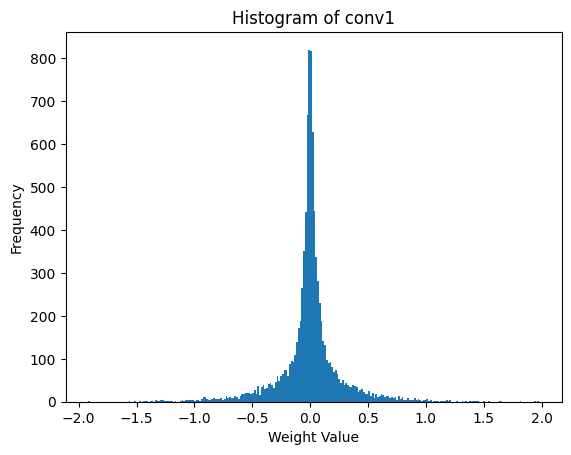

-1.9180801 1.9789636 -0.0006088594 0.26923782


In [4]:
__conv1 = model.conv1.weight.data
show_plot(__conv1, "conv1")

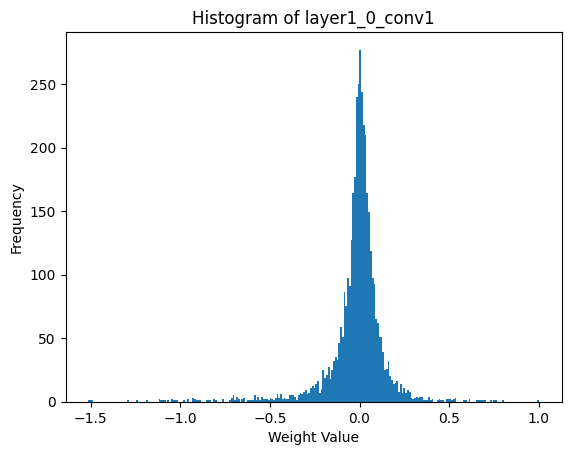

-1.5129721 1.0011052 -0.015311795 0.16769269


In [5]:
__layer1_0_conv1 = model.layer1[0].conv1.weight.data
show_plot(__layer1_0_conv1, "layer1_0_conv1")

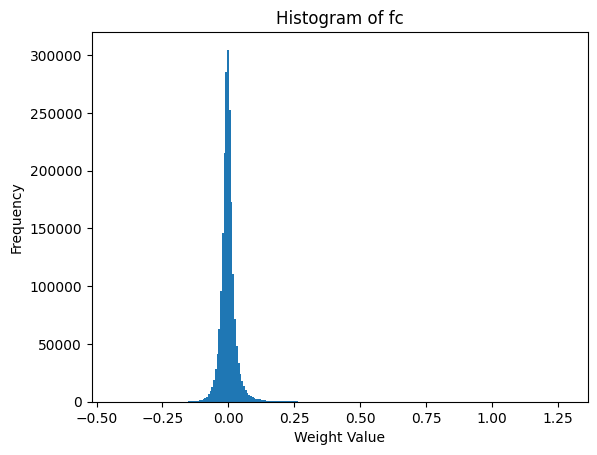

-0.43231362 1.2790387 9.732936e-07 0.040513273


In [6]:
__fc = model.fc.weight.data
show_plot(__fc, "fc")

- Check the fused network architecture

In [7]:
model.eval()
model = fuse_model(model)
print(print_size_of_model(model))
print(model.layer1[0])

Size (MB): 102.159626
102.159626
BottleNeck_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (1): ReLU()
  )
  (bn1): Identity()
  (conv2): ConvReLU2d(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
  )
  (bn2): Identity()
  (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
  (bn3): Identity()
  (relu): ReLU(inplace=True)
  (downsample): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): Identity()
  )
  (relu1): Identity()
  (relu2): Identity()
  (relu3): ReLU()
  (add): FloatFunctional(
    (activation_post_process): Identity()
  )
  (quant): QuantStub()
)


In [8]:
print(model.modules)

<bound method Module.modules of ResNet_quan(
  (conv1): ConvReLU2d(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
    (1): ReLU(inplace=True)
  )
  (bn1): Identity()
  (relu): Identity()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BottleNeck_quan(
      (conv1): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): ReLU()
      )
      (bn1): Identity()
      (conv2): ConvReLU2d(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): ReLU()
      )
      (bn2): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (bn3): Identity()
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
        (1): Identity()
      )
      (relu1): Identity()
      (relu2): Identity()
      (relu3): ReLU()
      (add): FloatFunc

# 2. Calibration for Post-Training Static Quantization

- Check the Quantization Configuration

In [9]:
# model.conv1.qconfig = torch.quantization.QConfig(
#     activation=torch.quantization.PlaceholderObserver.with_args(dtype=torch.qint8),
#     weight=torch.quantization.PlaceholderObserver.with_args(dtype=torch.qint8),
# )

# model.conv1.qconfig = torch.quantization.QConfig(
#     activation=torch.quantization.NoopObserver,
#     weight=torch.quantization.NoopObserver.with_args(dtype=torch.qint8),
# )
model.qconfig = torch.quantization.get_default_qconfig("x86")
print("Post Training Quantization Prepare: Inserting Observers")

Post Training Quantization Prepare: Inserting Observers


In [10]:
torch.quantization.prepare(model, inplace=True)

print("Post Training Quantization Prepare: Inserting Observers")

Post Training Quantization Prepare: Inserting Observers


/home/lee/miniconda3/envs/py312/lib/python3.12/site-packages/torch/ao/quantization/observer.py:220: UserWarning: Please use quant_min and quant_max to specify the range for observers.                     reduce_range will be deprecated in a future release of PyTorch.
  warnings.warn(


In [11]:
# 모델의 모든 모듈을 순회합니다.
for name, module in model.named_modules():
    # 모듈의 qconfig 속성을 확인합니다.
    if hasattr(module, "qconfig") and module.qconfig is not None:
        print(f"Module {name} has qconfig: {module.qconfig}")
    else:
        print(f"Module {name} does not have a qconfig")

Module  has qconfig: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function _add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x75418f9999e0>}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){'factory_kwargs': <function _add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x75418f9999e0>})
Module conv1 has qconfig: QConfig(activation=functools.partial(<class 'torch.ao.quantization.observer.HistogramObserver'>, reduce_range=True){'factory_kwargs': <function _add_module_to_qconfig_obs_ctr.<locals>.get_factory_kwargs_based_on_module_device at 0x75418fbf9440>}, weight=functools.partial(<class 'torch.ao.quantization.observer.PerChannelMinMaxObserver'>, dtype=torch.qint8, qscheme=torch.per_channel_symmetric){'factory_kwargs': <function _add

- Inference with the representative dataset (calculate the quantization parameters)

In [12]:
criterion = nn.CrossEntropyLoss()
train_loader, test_loader = GetDataset(
    dataset_name="ImageNet",
    device=device,
    root="data",
    batch_size=256,
    num_workers=8,
)
_, _ = SingleEpochEval(model, train_loader, criterion, "cuda", 2)
print("Post Training Quantization: Calibration done")

  0%|          | 1/5005 [00:03<5:10:09,  3.72s/it]

Post Training Quantization: Calibration done


- Convert to quantized model

In [13]:
device = "cpu"
model.to(device)
# torch.quantization.convert(model, inplace=True)

# quantization 비활성화할 레이어 설정
no_quant_layers = [model.conv1, model.bn1]

for name, module in model.named_modules():
    if (
        isinstance(
            module,
            (nn.intrinsic.ConvBn2d, nn.intrinsic.ConvReLU2d),
        )
        and module not in no_quant_layers
    ):
        print(name, module)
        module = torch.quantization.convert(module, inplace=True)

print("Post Training Quantization: Convert done")
print_size_of_model(model)

layer1.0.conv1 ConvReLU2d(
  (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (activation_post_process): HistogramObserver(min_val=0.0, max_val=19.868104934692383)
)
layer1.0.conv2 ConvReLU2d(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (activation_post_process): HistogramObserver(min_val=0.0, max_val=25.477624893188477)
)
layer1.1.conv1 ConvReLU2d(
  (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (activation_post_process): HistogramObserver(min_val=0.0, max_val=31.43402099609375)
)
layer1.1.conv2 ConvReLU2d(
  (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU()
  (activation_post_process): HistogramObserver(min_val=0.0, max_val=26.45480728149414)
)
layer1.2.conv1 ConvReLU2d(
  (0): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1))
  (1): ReLU()
  (activation_post_process): HistogramObserver(min_val=0.0, max_val=20.847946166992188)
)
layer1.2.conv2 ConvReLU2d(
 

55.88915

# 3. Complete 

In [14]:
check_accuracy(model=model, device="cpu", batch_size=25)
print("Post Training Quantization: Eval done")

NotImplementedError: Could not run 'quantized::conv2d.new' with arguments from the 'CPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'quantized::conv2d.new' is only available for these backends: [Meta, QuantizedCPU, QuantizedCUDA, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradXLA, AutogradMPS, AutogradXPU, AutogradHPU, AutogradLazy, AutogradMeta, Tracer, AutocastCPU, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

Meta: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/MetaFallbackKernel.cpp:23 [backend fallback]
QuantizedCPU: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/native/quantized/cpu/qconv.cpp:1912 [kernel]
QuantizedCUDA: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/native/quantized/cudnn/Conv.cpp:388 [kernel]
BackendSelect: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/PythonFallbackKernel.cpp:154 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/functorch/DynamicLayer.cpp:498 [backend fallback]
Functionalize: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/FunctionalizeFallbackKernel.cpp:324 [backend fallback]
Named: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/NamedRegistrations.cpp:7 [backend fallback]
Conjugate: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/native/NegateFallback.cpp:19 [backend fallback]
ZeroTensor: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:86 [backend fallback]
AutogradOther: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:53 [backend fallback]
AutogradCPU: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:57 [backend fallback]
AutogradCUDA: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:65 [backend fallback]
AutogradXLA: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:69 [backend fallback]
AutogradMPS: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:77 [backend fallback]
AutogradXPU: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:61 [backend fallback]
AutogradHPU: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:90 [backend fallback]
AutogradLazy: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:73 [backend fallback]
AutogradMeta: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/VariableFallbackKernel.cpp:81 [backend fallback]
Tracer: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/torch/csrc/autograd/TraceTypeManual.cpp:297 [backend fallback]
AutocastCPU: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/autocast_mode.cpp:378 [backend fallback]
AutocastCUDA: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/autocast_mode.cpp:244 [backend fallback]
FuncTorchBatched: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:720 [backend fallback]
BatchedNestedTensor: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:746 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/functorch/VmapModeRegistrations.cpp:28 [backend fallback]
Batched: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/functorch/TensorWrapper.cpp:203 [backend fallback]
PythonTLSSnapshot: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/PythonFallbackKernel.cpp:162 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/functorch/DynamicLayer.cpp:494 [backend fallback]
PreDispatch: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/PythonFallbackKernel.cpp:166 [backend fallback]
PythonDispatcher: registered at /opt/conda/conda-bld/pytorch_1708025845206/work/aten/src/ATen/core/PythonFallbackKernel.cpp:158 [backend fallback]


In [ ]:
# 가중치를 가져옵니다.
__q__conv1 = model.conv1.weight().int_repr()
show_plot(__q__conv1, "conv1")

In [ ]:
# 가중치를 가져옵니다.
__q__layer1_0_conv1 = model.layer1[0].conv1.weight().int_repr()
show_plot(__q__layer1_0_conv1, "layer1_0_conv1")

In [ ]:
# 가중치를 가져옵니다.
__q__fc = model.fc.weight().int_repr()
show_plot(__q__fc, "fc")